In [ ]:
import geopandas as gpd
from rasterio.features import geometry_window
from shapely.geometry import box
import rasterio
from rasterio.windows import Window
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



## Ajustement de Shapefile avec l’image Raster

Shapefile clipped to raster extent and saved as C:/Users/hp/Desktop/DataPreparation/Clipped-Mask/clipped_shapefile.shp


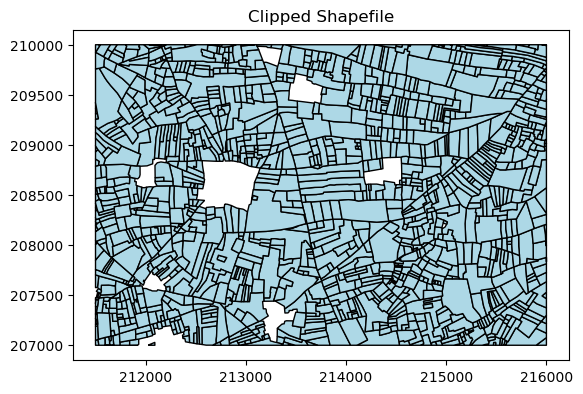

In [30]:
# Paths to your files
tiff_path = 'C:/Users/hp/Desktop/DataPreparation/OriginalData/18-12-L.tif'
shapefile_path = 'C:/Users/hp/Desktop/DataPreparation/OriginalData/parcellaire S2 V1.shp'
clipped_shapefile_path = 'C:/Users/hp/Desktop/DataPreparation/Clipped-Mask/clipped_shapefile.shp'

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

# Open the TIFF file and get its bounding box
with rasterio.open(tiff_path) as src:
    bounds = src.bounds

# Create a bounding box polygon from the raster bounds
raster_bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

# Clip the shapefile to the bounding box
clipped_shapefile = shapefile.clip(raster_bbox)

# Save the clipped shapefile
clipped_shapefile.to_file(clipped_shapefile_path)

print(f"Shapefile clipped to raster extent and saved as {output_shapefile_path}")

# Load the clipped shapefile
clipped_shapefile = gpd.read_file(clipped_shapefile_path)

# Plot the clipped shapefile
clipped_shapefile.plot(edgecolor='black', facecolor='lightblue')

# Add a title to the plot
plt.title('Clipped Shapefile')

# Show the plot
plt.show()


## Conversion de Shapefile en Raster dans QGIS

## Découpage des images Raster en 100 régions

In [31]:
# Paths to the input images
input_image_path = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/input.tif'
expected_output_image_path = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/clipped_shapefile.tif'

# Paths to the output directories
input_output_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_input/'
expected_output_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_expected_output/'

# Create output directories if they don't exist
os.makedirs(input_output_dir, exist_ok=True)
os.makedirs(expected_output_dir, exist_ok=True)

def split_image(image_path, output_dir, prefix):
    # Open the image
    with rasterio.open(image_path) as src:
        width = src.width
        height = src.height

        # Determine the number of rows and columns to split into
        n_rows = 10
        n_cols = 10
        block_width = width // n_cols
        block_height = height // n_rows

        count = 1
        for i in range(n_rows):
            for j in range(n_cols):
                # Define the window
                window = Window(j * block_width, i * block_height, block_width, block_height)
                transform = src.window_transform(window)

                # Read the window and save it as a new file
                with rasterio.open(
                    os.path.join(output_dir, f"{prefix}_{count}.tif"),
                    'w',
                    driver='GTiff',
                    height=block_height,
                    width=block_width,
                    count=src.count,
                    dtype=src.dtypes[0],
                    crs=src.crs,
                    transform=transform,
                ) as dst:
                    dst.write(src.read(window=window))
                
                count += 1

# Split the images
split_image(input_image_path, input_output_dir, 'img')
split_image(expected_output_image_path, expected_output_dir, 'mask')

# Print a success message
print("Image splitting process completed successfully.")

Image splitting process completed successfully.


## Vérification des dimensions des images input et expected output

In [32]:
def get_image_dimensions(directory):
    image_dimensions = {}
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_dimensions[filename] = (width, height)
    return image_dimensions

def compare_image_dimensions(input_dir, expected_output_dir):
    input_dimensions = get_image_dimensions(input_dir)
    expected_output_dimensions = get_image_dimensions(expected_output_dir)
    
    for filename in input_dimensions:
        if filename.startswith('img_'):  # Assuming input images start with 'img_'
            corresponding_mask = filename.replace('img_', 'mask_', 1)
            if corresponding_mask in expected_output_dimensions:
                input_dim = input_dimensions[filename]
                expected_dim = expected_output_dimensions[corresponding_mask]
                if input_dim != expected_dim:
                    print(f"Dimensions mismatch found between {filename} and {corresponding_mask}. Please resize images.")
                    return  # Stop after the first mismatch
    print("All images have matching dimensions with their corresponding masks.")

# Directories containing the .tif files
input_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_input/'
expected_output_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_expected_output/'

compare_image_dimensions(input_dir, expected_output_dir)


Dimensions mismatch found between img_1.tif and mask_1.tif. Please resize images.


##  Redimensionnement des images Raster d’entrée en sorte quelles soient de meme dimensions que expected output

In [33]:
# Define the input and output directories
input_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_input'
output_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_resized_input'
os.makedirs(output_dir, exist_ok=True)

# Target dimensions
target_width, target_height = 450, 300

# Resize all images in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)
        resized_img = img.resize((target_width, target_height), Image.LANCZOS)
        
        # Save the resized image to the output directory
        output_path = os.path.join(output_dir, filename)
        resized_img.save(output_path)

print(f"All images have been resized and saved to {output_dir}")


All images have been resized and saved to C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_resized_input


##  Vérification des dimensions des images input et expected output pour sassurer de redimensionnement

In [34]:
# Directories containing the .tif files
input_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_resized_input/'
expected_output_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_expected_output/'

compare_image_dimensions(input_dir, expected_output_dir)


All images have matching dimensions with their corresponding masks.


## Conversion des images expected output en noir et blanc

In [38]:
import os
import numpy as np
import cv2
from PIL import Image

def process_image(image_path, output_dir):
    # Read the image using PIL
    img = Image.open(image_path)
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Convert image to grayscale (if it's not already)
    if len(img_array.shape) == 3:  # Check if image has multiple channels (color)
        gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img_array

    # Create an empty white image
    contour_img = np.ones_like(gray_img) * 255

    # Find unique colors (intensity values) in the grayscale image
    unique_colors = np.unique(gray_img)
    
    for color in unique_colors:
        if color == 255:  # Skip white color
            continue

        # Create a binary image where this color is white and everything else is black
        binary_img = np.zeros_like(gray_img)
        binary_img[gray_img == color] = 255

        # Find contours
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours
        cv2.drawContours(contour_img, contours, -1, (0, 0, 0), 1)

    # Save the contour image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, contour_img)

def process_all_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Track the number of processed images
    num_processed = 0
    
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            image_path = os.path.join(input_folder, filename)
            process_image(image_path, output_folder)
            num_processed += 1
    
    print(f"Processing complete. {num_processed} images were processed and saved to '{output_folder}'.")

# Path to the folder containing the images
input_folder = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_expected_output/'
# Path to the folder where contour images will be saved
output_folder = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/black_white_raster_expected_output/'

process_all_images(input_folder, output_folder)


Processing complete. 100 images were processed and saved to 'C:/Users/hp/Desktop/DataPreparation/Raster-data/black_white_raster_expected_output/'.


## Division des images et leurs masques en ensemble d’entrainement et test

In [51]:
import os
import shutil

# Define directories
raster_mask_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/black_white_raster_expected_output/'
raster_img_dir = 'C:/Users/hp/Desktop/DataPreparation/Raster-data/raster_resized_input/'
output_dir = 'C:/Users/hp/Desktop/DataPreparation/Prepared-Data/work'

# Define subdirectories for train and test
train_mask_dir = os.path.join(output_dir, 'train/mask/')
test_mask_dir = os.path.join(output_dir, 'test/mask/')
train_img_dir = os.path.join(output_dir, 'train/img/')
test_img_dir = os.path.join(output_dir, 'test/img/')

# Create directories if they do not exist
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)

# Process mask files
mask_files = sorted([f for f in os.listdir(raster_mask_dir) if f.startswith('mask_') and f.endswith('.tif')])
train_mask_files = mask_files[:80]
test_mask_files = mask_files[80:]

for i, file in enumerate(train_mask_files):
    new_name = f'mask_{i + 1}.tif'
    shutil.copy(os.path.join(raster_mask_dir, file), os.path.join(train_mask_dir, new_name))

for i, file in enumerate(test_mask_files):
    new_name = f'mask_{i + 1}.tif'
    shutil.copy(os.path.join(raster_mask_dir, file), os.path.join(test_mask_dir, new_name))

print("Masks have been organized and renamed for training and testing sets.")

# Process image files
img_files = sorted([f for f in os.listdir(raster_img_dir) if f.startswith('img_') and f.endswith('.tif')])
train_img_files = img_files[:80]
test_img_files = img_files[80:]

for i, file in enumerate(train_img_files):
    new_name = f'img_{i + 1}.tif'
    shutil.copy(os.path.join(raster_img_dir, file), os.path.join(train_img_dir, new_name))

for i, file in enumerate(test_img_files):
    new_name = f'img_{i + 1}.tif'
    shutil.copy(os.path.join(raster_img_dir, file), os.path.join(test_img_dir, new_name))

print("Images have been organized and renamed for training and testing sets.")


Masks have been organized and renamed for training and testing sets.
Images have been organized and renamed for training and testing sets.
